# The Walking DEAD - um modelo de difusão social para o apocalipse zumbi!

Por uma série de motivos (inclua-se aqui meu problema de pesquisa de tese, curiosidade sobre ABM's, o vício da minha cunhada em Netflix) cheguei até o excelente artigo de Riebling e Schmitz (2016) intitulado **ZombieApocalypse: Modeling the social dynamics of infection and rejection.** O artigo é aberto e pode ser visualizado [aqui](http://journals.sagepub.com/doi/full/10.1177/2059799115622767). Sua ideia é bastante engenhosa: eles usam um modelo de difusão em redes (*network diffusion model*) para modelizar o alastrar de uma infecção zumbi generalizada. Neste post, vamos replicar uma versão simples do modelo tentando entender a implementação de um modelo de simulação computacional de agentes em redes.

![](http://weknowyourdreams.com/images/zombies/zombies-04.jpg)

Os modelos de difusão são amplamente utilizados para estudar padrões de infecção e contágio na área da saúde utilizando técnicas da Análise de Redes Sociais (ARS). São um tipo de *Agent Based Modelin* ou Modelagem Baseada em Agentes, modelos onde agentes e suas ações são simulados computacionalmente. O [Rogério Barbosa](https://www.facebook.com/rogerio.barbosa.7528) tem uma série de posts muito bons sobre o método que podem ser vistos [aqui](https://sociaisemetodos.wordpress.com/2016/04/20/cachorros-artificiais-agentes-de-agent-based-modeling-usando-r-parte-1/). Na implementação desse tipo de modelos, o pesquisador programa as características dos agentes e do mundo social mais fundamentais de que precisa para tentar entender como os fenômenos no nível macro emergem das interações.

Para simular o *The Walking Dead*, vamos usar a distribuição Anaconda do Python 3.5. A distribuição pode ser baixada [aqui](https://www.continuum.io/downloads). Se é a primeira vez que você instala o Python, é importante instalar também alguns pacotes que não vem como *default* na distro Anaconda.

Se você é usuário de Windows, abra o prompt de comando clicando no botão do Windows e pesquisando por `cmd`. Se você é usuário de Ubuntu, abra o terminal com `Ctrl + Alt + t`. Para instalar os pacotes, use os comandos:

Vamos aos códigos.

## Carregando as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
from nxsim import NetworkSimulation, BaseNetworkAgent, BaseLoggingAgent

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('notebook') #colocando um aspecto mais atrativo nos plots com seaborn

## Algumas funções úteis

In [2]:
def census_to_df(log, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the sum of agents with a given state_id at 
    every time interval of the simulation for every run of the simulation as a pandas
    DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        census = [sum([1 for node_id, state in g.items() 
                       if node_id != 'topology' and state['id'] == state_id]) 
                  for t, g in trial.items()]
        D[name] = census      
    return pd.DataFrame(D)

def friends_to_the_end(log, num_trials=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the number of human friends connected
    to every human at every time interval of the simulation for every run of
    the simulation as a pandas DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        friends = [np.mean([state['friends'] for node_id, state in g.items() 
                       if node_id != 'topology' and state['id'] == 0]) 
                  for t, g in trial.items()]
        D[name] = friends    
    return pd.DataFrame(D)

def edge_count_to_df(log, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the edge count for the topology at every
    time interval of the simulation for every run of the simulation as a pandas
    DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        edge_count = [len(trial[key]['topology']) for key in trial]
        D[name] = edge_count
    return pd.DataFrame(D)

## Topologia

Vamos declarar a topologia da rede sobre a qual as simulações irão acontecer. A principal diferença entre os modelos de difusão social e os ABM's comuns reside no pressuposto da independência das observações. Esse pressuposto não se sustenta em estruturas relacionais já que a mudança de apenas um laço muda toda a configuração da rede. O pacote *nxsim* nos permite rodar um modelo de simulações apenas dentro da topologia de uma rede dada. Vamos simular uma rede livre de escala com 100 nós, ou 100 pessoas.

In [4]:
number_of_nodes = 100
G = nx.scale_free_graph(number_of_nodes).to_undirected()

## Classe de agentes

### Cenário 1 - Infestação Zumbi

Vamos agora definir a classe de agentes que nos interessa num cenário básico e as ações dos agentes. Nesse modelo preliminar, o que acontece nas rodadas é o seguinte: O estado de *humano* é definido como `self.state['id']==0` e o estado *Zumbi* como `self.state['id']==1`. A cada rodada, se o agente é humano ele verifica se tem pessoas próximas, "vizinhos", que estão infectados. Joga-se dados e se o valor obtido for menor do que o limite da infecção, ele se infecta. Depois, conta-se os amigos que ainda são humanos.

In [5]:
class ZombieMassiveOutbreak(BaseNetworkAgent):
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
        self.inf_prob = 0.2

    def run(self):
        while True:
            if self.state['id'] == 0:
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            else:
                yield self.env.event()

    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.inf_prob:
                self.state['id'] = 1
                print(self.env.now, self.id, '<--', neighbor.id, sep='\t')
                break
                                
    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

Para iniciar a simulação, primeiro estabelecemos todos como humanos e escolhemos um "paciente zero", o primeiro zumbi! Nessa simulação, serão feitas até 28 rodadas. O processo todo será repetido 100 vezes.

In [6]:
# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=ZombieMassiveOutbreak, 
                        max_time=28, num_trials=100, logging_interval=1.0, dir_path='sim_01')

# Running the simulation
sim.run_simulation()

Starting simulations...
---Trial 0---
Setting up agents...
1	0	<--	49
1	17	<--	0
1	19	<--	0
1	25	<--	0
1	37	<--	0
1	38	<--	0
1	63	<--	0
1	82	<--	19
2	1	<--	0
2	4	<--	1
2	6	<--	49
2	12	<--	0
2	15	<--	1
2	26	<--	0
2	28	<--	6
2	35	<--	4
2	43	<--	0
2	54	<--	1
2	55	<--	17
2	57	<--	0
2	67	<--	1
2	69	<--	1
2	80	<--	1
2	94	<--	1
2	97	<--	6
3	2	<--	1
3	3	<--	35
3	8	<--	2
3	10	<--	0
3	21	<--	2
3	23	<--	19
3	30	<--	2
3	47	<--	6
3	48	<--	2
3	58	<--	2
3	59	<--	1
3	73	<--	48
3	77	<--	23
3	86	<--	2
3	91	<--	2
3	93	<--	0
4	5	<--	0
4	16	<--	19
4	20	<--	30
4	24	<--	6
4	31	<--	1
4	32	<--	17
4	39	<--	12
4	40	<--	0
4	42	<--	43
4	52	<--	1
4	53	<--	24
4	71	<--	0
4	75	<--	2
4	83	<--	1
4	89	<--	16
4	99	<--	58
5	11	<--	8
5	13	<--	0
5	29	<--	55
5	44	<--	0
5	62	<--	1
5	72	<--	1
5	76	<--	6
5	78	<--	71
5	92	<--	2
6	14	<--	2
6	27	<--	0
6	51	<--	6
6	79	<--	1
6	84	<--	1
7	7	<--	2
7	33	<--	7
7	36	<--	1
7	41	<--	1
7	60	<--	20
7	65	<--	6
7	87	<--	6
8	34	<--	2
8	70	<--	6
9	50	<--	43
9	61	<--	16
9	66	<--	6
9	81	<--	32
9	85

Do mesmo modo como a modelagem baseada em agentes, o modelo de difusão social está preocupado com a análise dos resultados macro das interações. Vamos olhar para como as infecções acontecem no tempo.

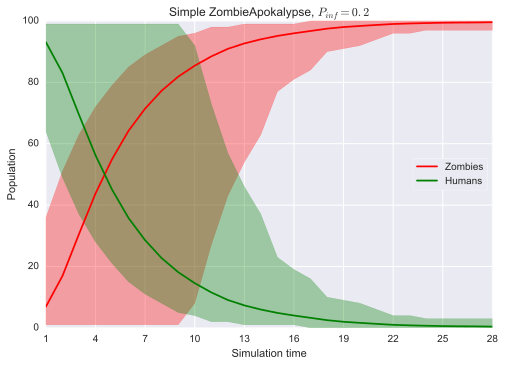

In [9]:
zombies = census_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_01').T
humans = census_to_df(BaseLoggingAgent, 100, 0, dir_path='sim_01').T

plt.plot(zombies.mean(), color='r')
plt.fill_between(zombies.columns, zombies.max(), zombies.min(), color='r', alpha=.33)

plt.plot(humans.mean(), color='g')
plt.fill_between(humans.columns, humans.max(), humans.min(), color='g', alpha=.33)

plt.title('Simple ZombieApokalypse, $P_{inf}=0.2$')
plt.legend(['Zombies', 'Humans'], loc=7, frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time')
plt.show()

### Cenário 2 - Escapar!!

Vamos programar um segundo cenário para nossa infestação zumbi. Se eu algum dia encontrasse com um zumbi, sem pestenejar, sairia correndo desenfreadamente sem olhar pra trás e gritando como uma garotinha(!!!). Nossos agentes virtuais também devem ter esse direito. Agora eles podem tentar escapar.

Na nova simulação, além de tudo o que já acontecia, antes de qualquer coisa, nosso agente pode perceber aqueles próximos que se tornaram zumbis e tentar escapar. Se os dados forem menores do que a "marca" de correr (`self.run_prob = 0.05`), o laço entre esses agentes é desfeito e o nosso agente pode sair gritando como uma garotinha livre do seu amigo zumbi (pelo menos desse).

In [10]:
class ZombieEscape(BaseNetworkAgent):
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
        self.inf_prob = 0.3
        self.run_prob = 0.05

    def run(self):
        while True:
            if self.state['id'] == 0:
                self.run_you_fools()
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            else:
                yield self.env.event()

    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.inf_prob:
                self.state['id'] = 1 # zombie
                print('Infection:', self.env.now, self.id, '<--', neighbor.id, sep='\t')
                break
                
    def run_you_fools(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.run_prob:
                self.global_topology.remove_edge(self.id, neighbor.id)
                print('Rejection:', self.env.now, 'Edge:', self.id, neighbor.id, sep='\t')
                
    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

Rodando a simulação:

In [11]:
# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=ZombieEscape, 
                        max_time=28, num_trials=100, logging_interval=1.0, dir_path='sim_02')

# Running the simulation
sim.run_simulation()

Starting simulations...
---Trial 0---
Setting up agents...
Infection:	0	23	<--	77
Infection:	2	2	<--	23
Infection:	2	3	<--	2
Infection:	2	8	<--	2
Infection:	2	10	<--	2
Infection:	2	13	<--	8
Infection:	2	14	<--	2
Infection:	2	17	<--	2
Infection:	2	19	<--	17
Infection:	2	35	<--	3
Infection:	2	45	<--	2
Rejection:	2	Edge:	48	2
Rejection:	3	Edge:	0	19
Infection:	3	0	<--	3
Infection:	3	1	<--	2
Infection:	3	4	<--	2
Infection:	3	6	<--	1
Infection:	3	12	<--	0
Infection:	3	15	<--	2
Infection:	3	18	<--	1
Infection:	3	25	<--	1
Infection:	3	27	<--	0
Rejection:	3	Edge:	28	1
Infection:	3	28	<--	6
Infection:	3	32	<--	1
Infection:	3	33	<--	1
Rejection:	3	Edge:	34	2
Infection:	3	36	<--	2
Infection:	3	37	<--	0
Infection:	3	38	<--	0
Infection:	3	40	<--	1
Rejection:	3	Edge:	41	1
Infection:	3	42	<--	6
Infection:	3	47	<--	6
Infection:	3	49	<--	0
Infection:	3	54	<--	1
Infection:	3	57	<--	0
Infection:	3	58	<--	1
Infection:	3	59	<--	8
Infection:	3	65	<--	6
Infection:	3	68	<--	1
Infection:	3	75	<--	2
Infection:	

E agora, vamos ver como o número de zumbis e humanos se comporta no tempo:

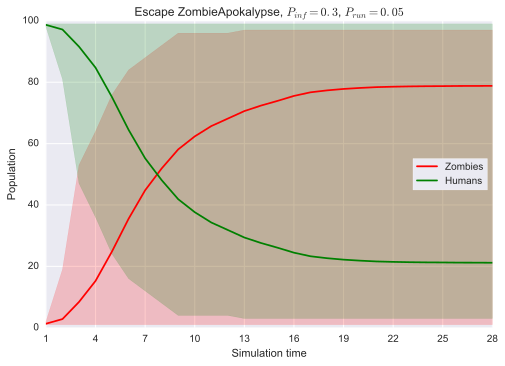

In [12]:
zombies = census_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_02').T
humans = census_to_df(BaseLoggingAgent, 100, 0, dir_path='sim_02').T

## For later comparisons:
mean_escape_zombies = zombies.mean()
mean_escape_humans = humans.mean()

plt.plot(zombies.mean(), color='r')
plt.fill_between(zombies.columns, zombies.max(), zombies.min(), color='r', alpha=.2)

plt.plot(humans.mean(), color='g')
plt.fill_between(humans.columns, humans.max(), humans.min(), color='g', alpha=.2)

plt.title('Escape ZombieApokalypse, $P_{inf} = 0.3$, $P_{run} = 0.05$')
plt.legend(['Zombies', 'Humans'], loc=7, frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time')
plt.show()

Agora, vamos comparar os dois cenários para verificar o remanescente humano em cada um.

/home/neylson/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


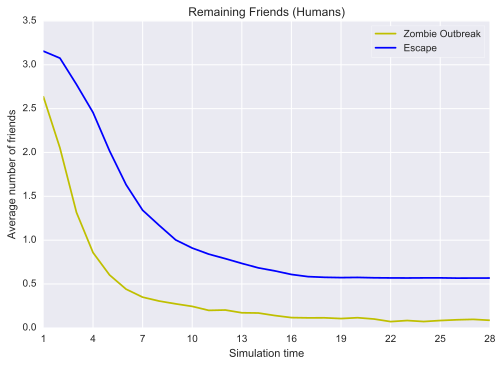

In [14]:
first_friends = friends_to_the_end(BaseLoggingAgent, 100, dir_path='sim_01').T
escape_friends = friends_to_the_end(BaseLoggingAgent, 100, dir_path='sim_02').T

plt.plot(first_friends.mean(), color='y')
plt.plot(escape_friends.mean(), color='b')

plt.title('Remaining Friends (Humans)')
plt.legend(['Zombie Outbreak','Escape'], loc='best', frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Average number of friends')
plt.xlabel('Simulation time')
plt.show()

Podemos visualizar o fenômeno do contágio na rede. Para isso, vamos escolher uma das simulações (`trial_id`) e plotar num grafo os nós humanos e os nós infectados.

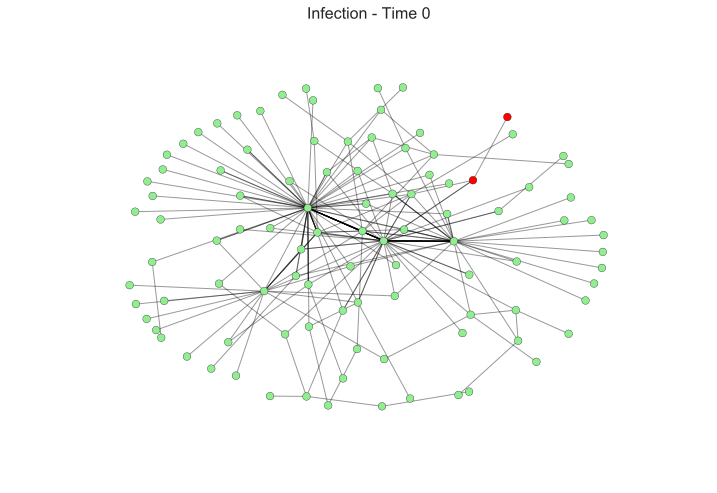

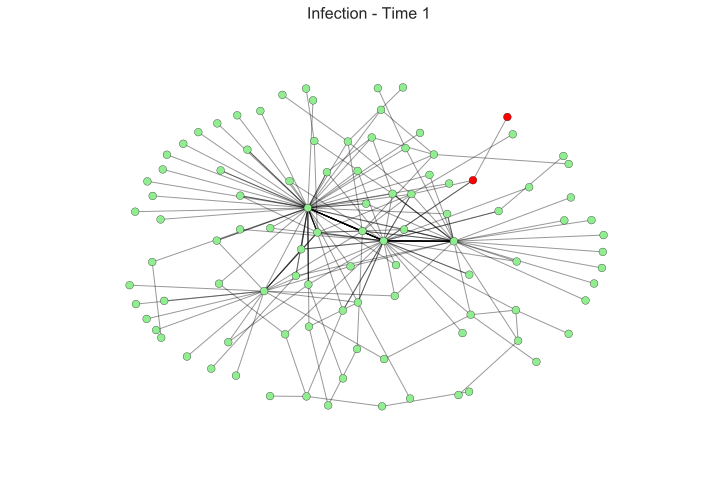

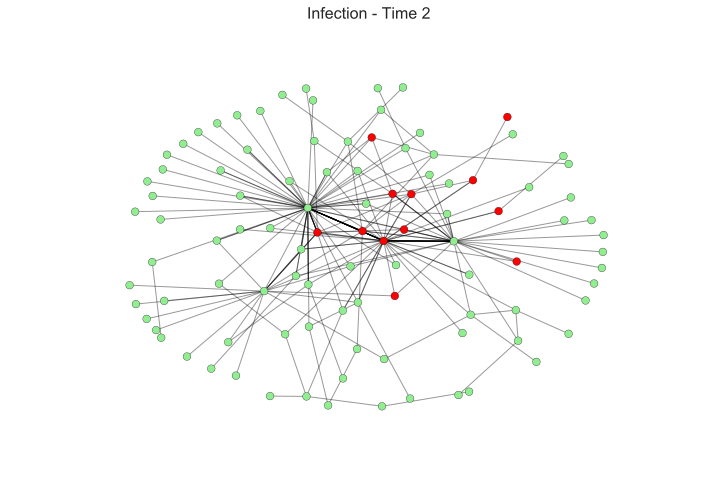

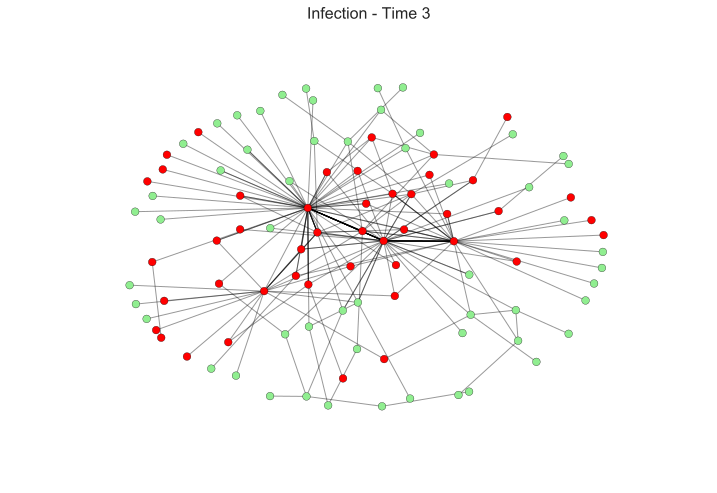

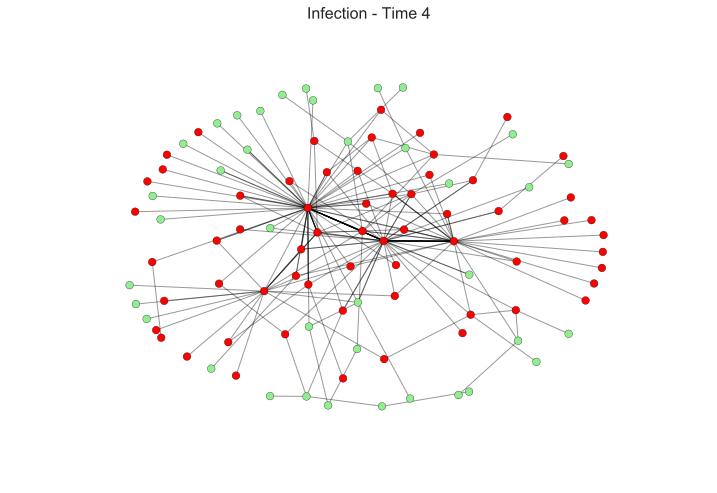

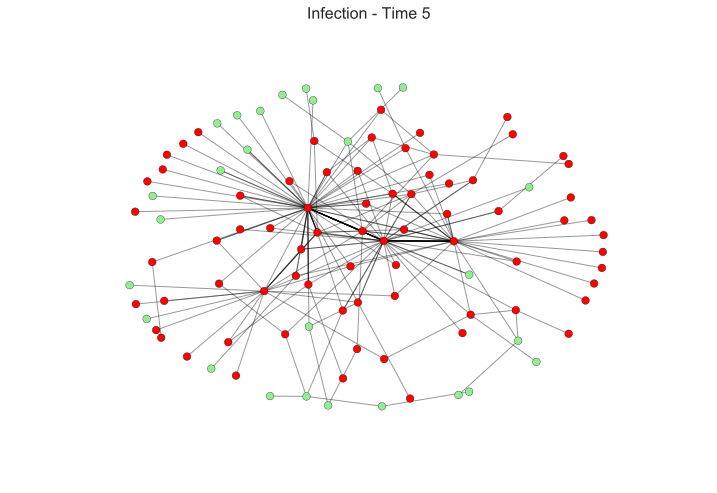

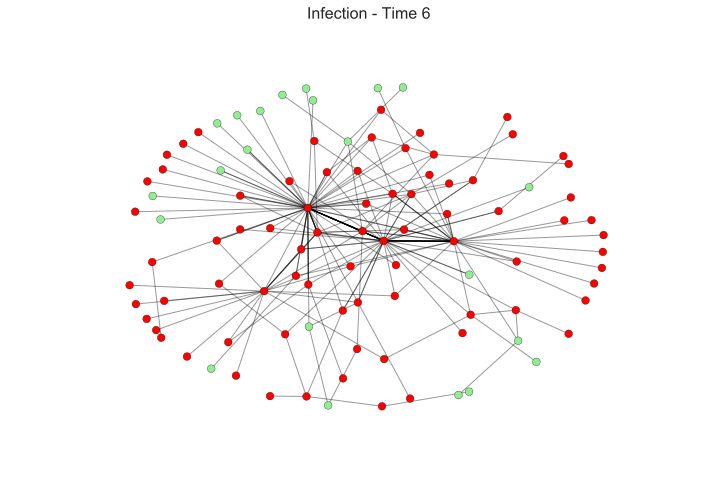

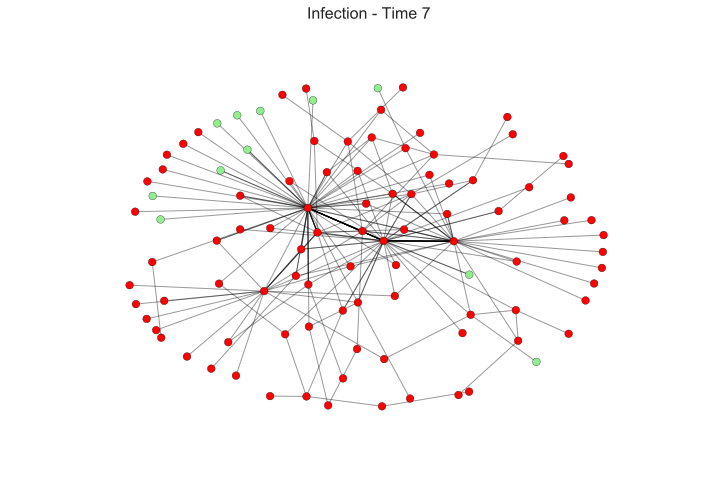

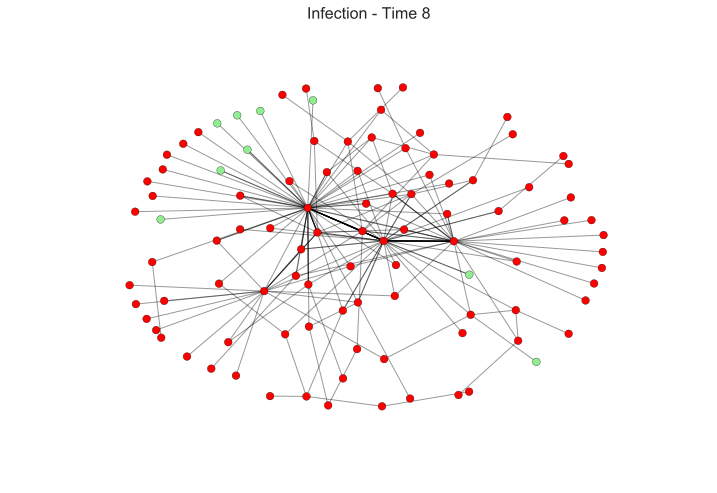

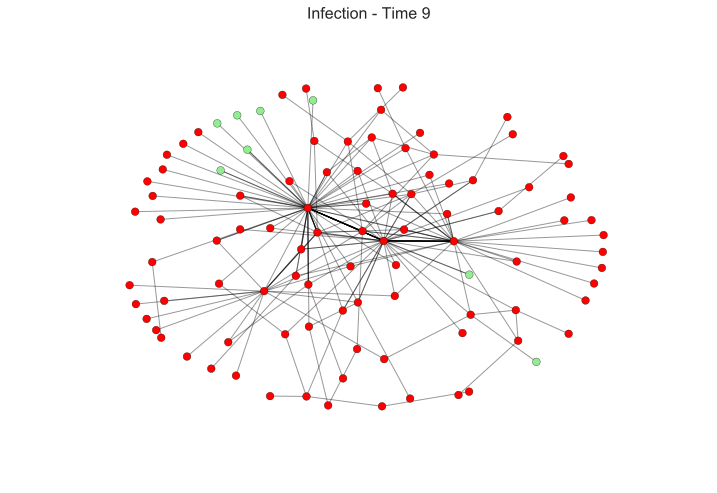

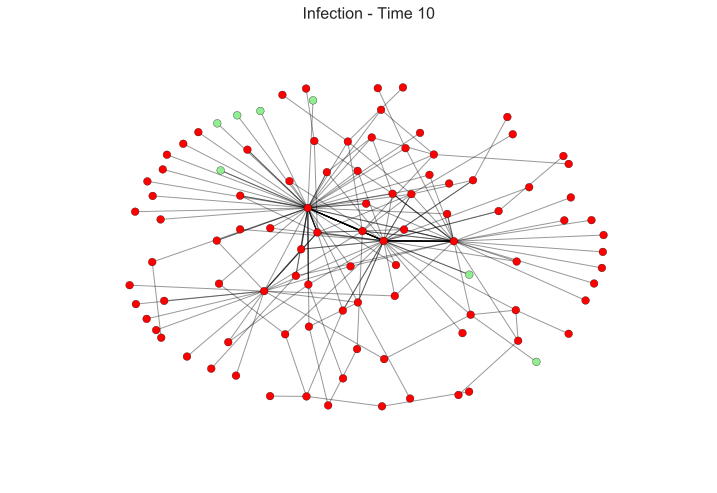

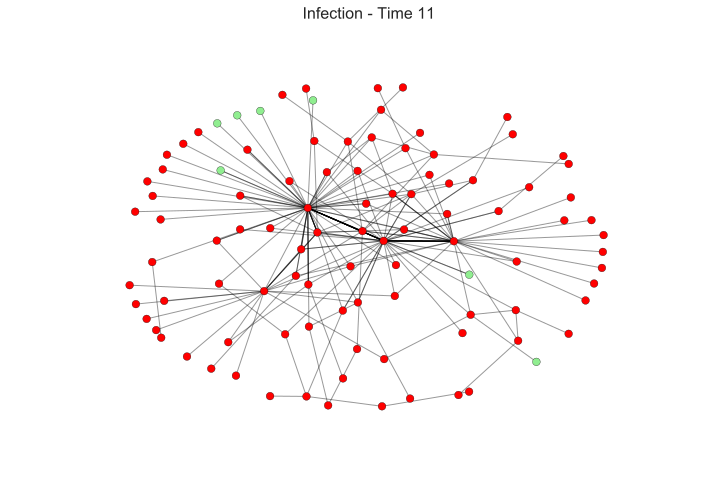

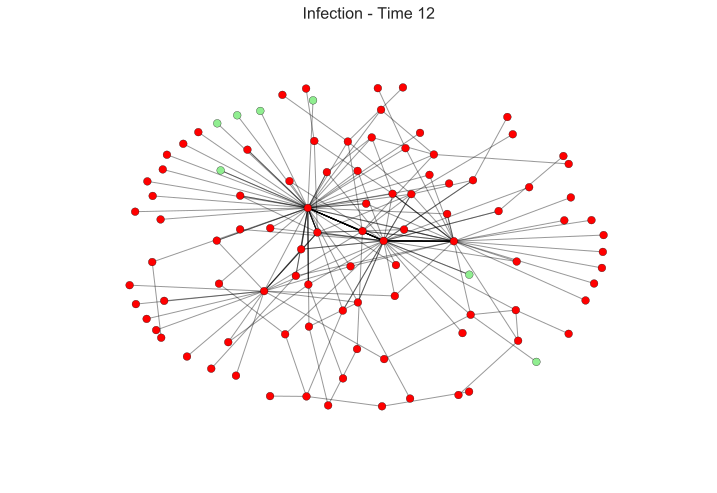

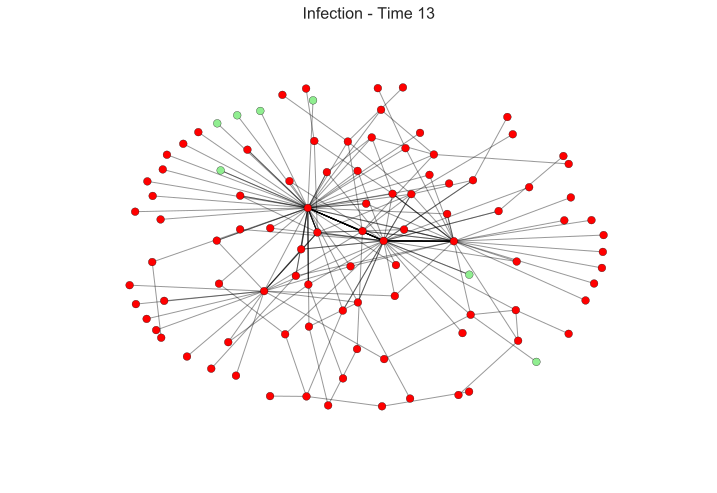

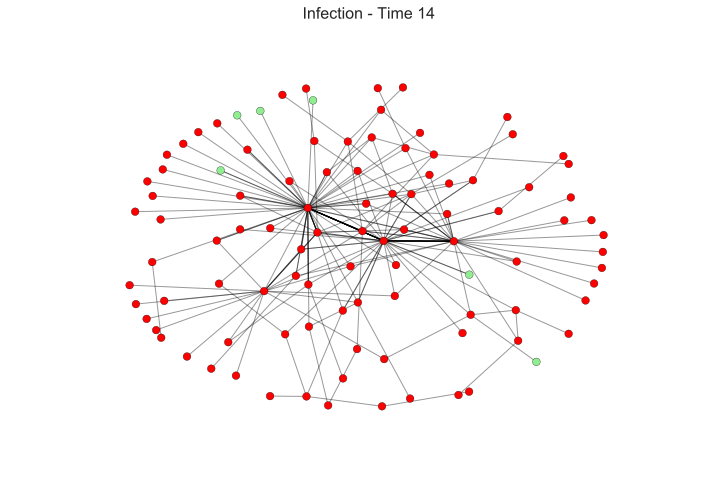

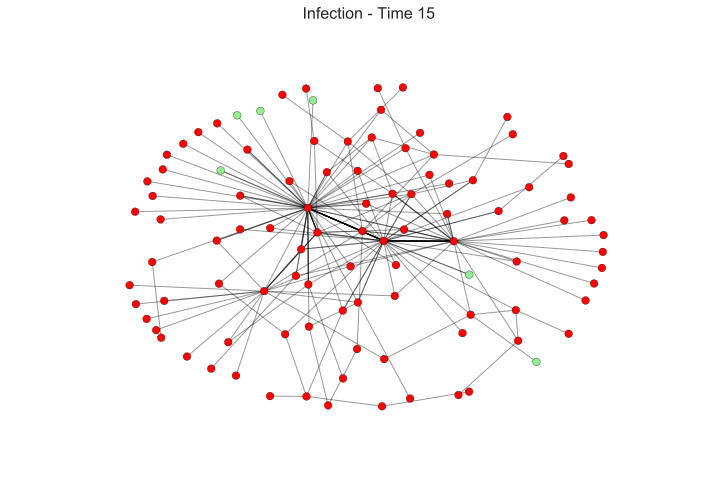

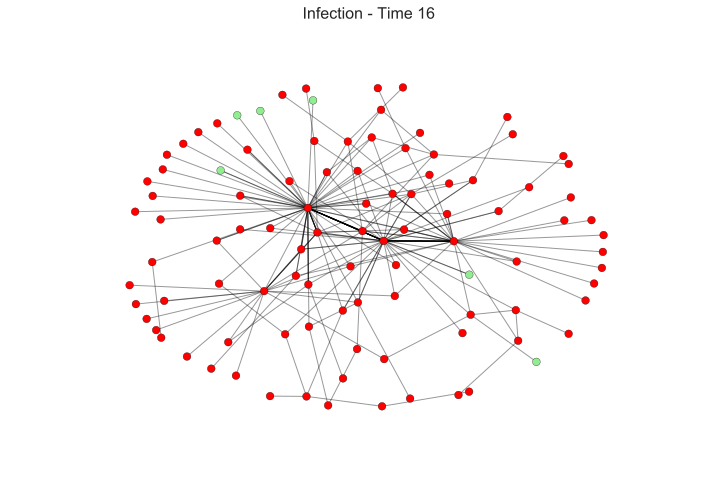

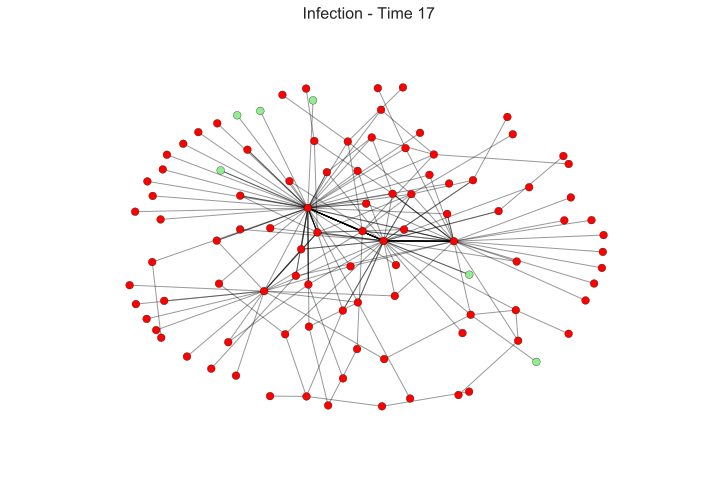

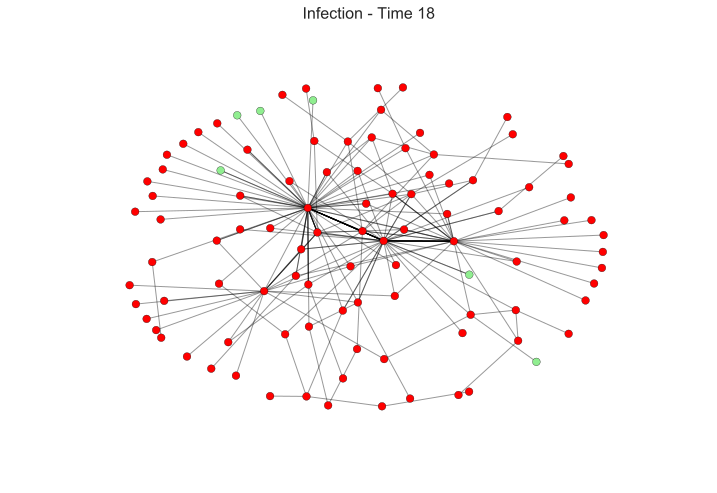

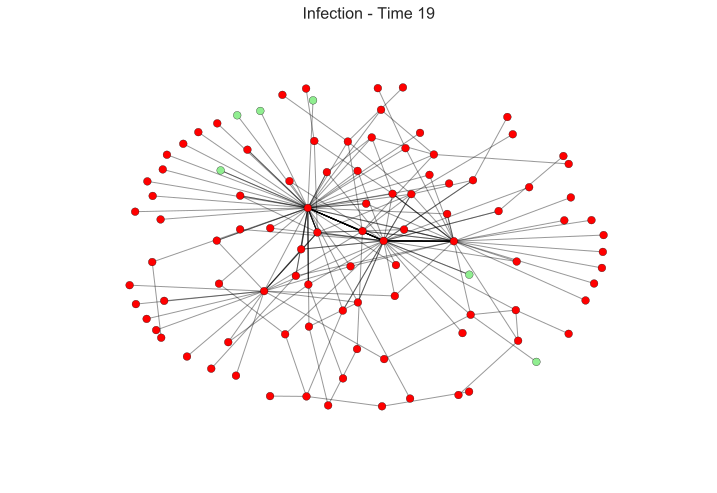

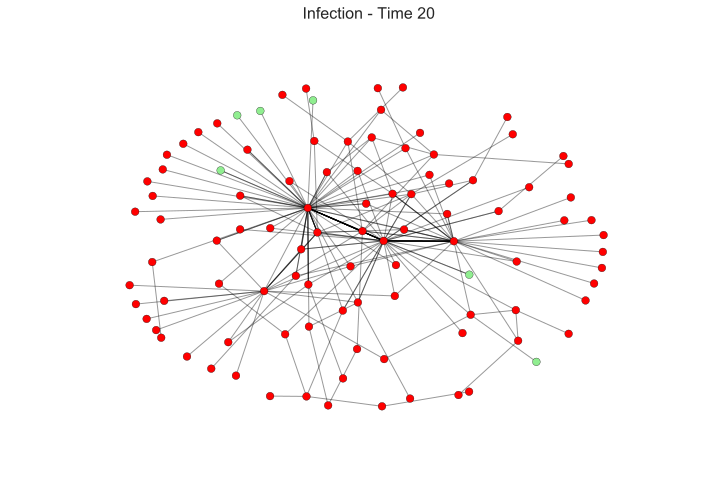

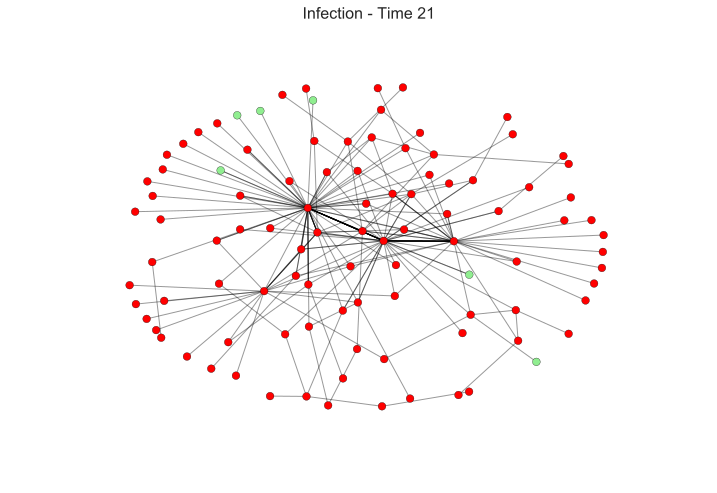

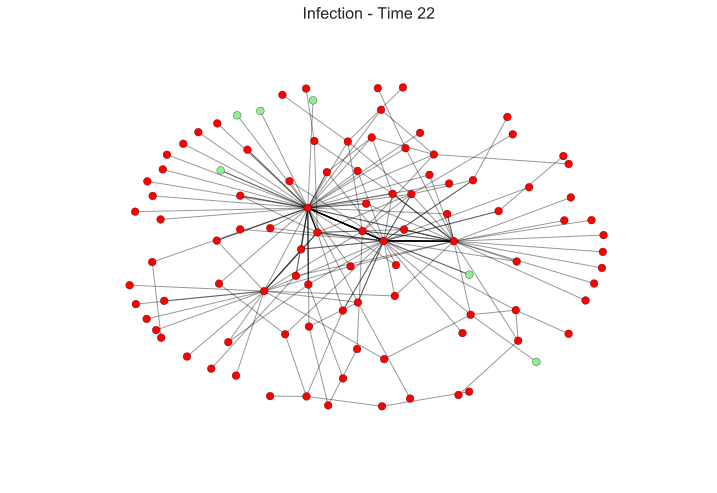

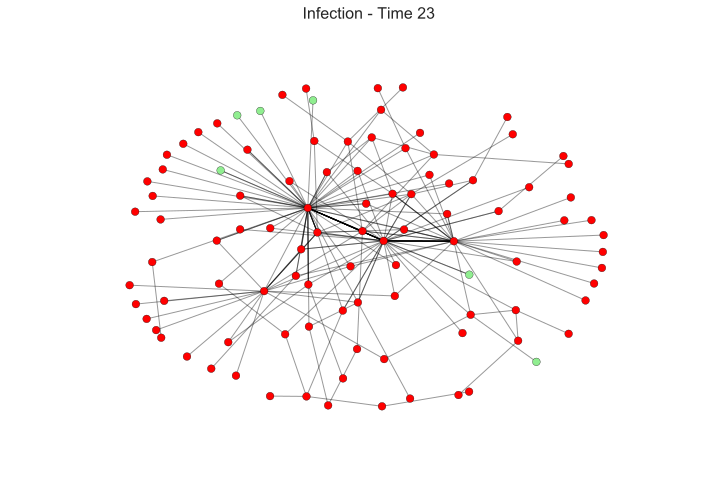

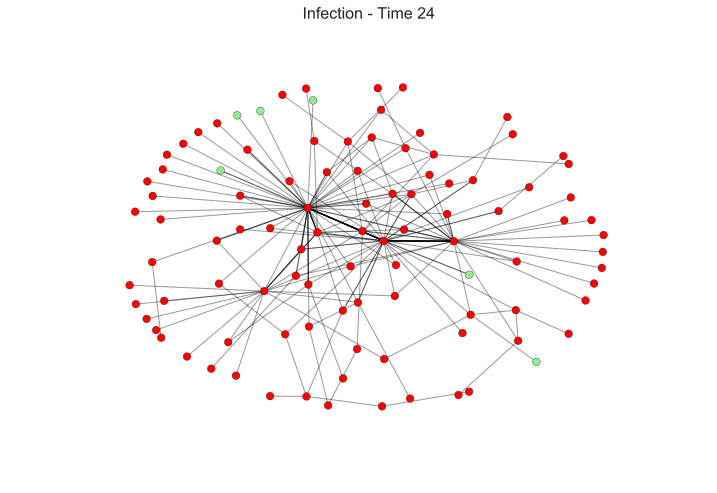

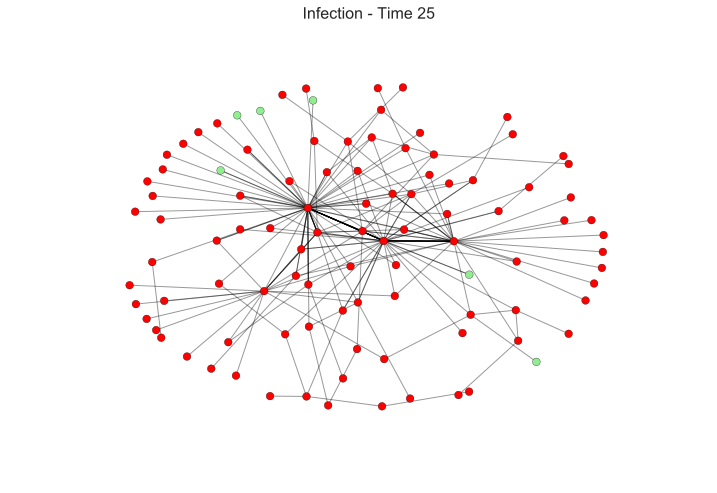

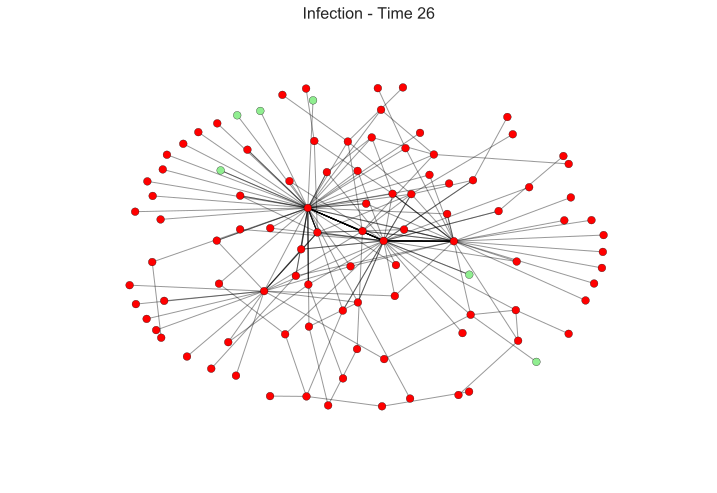

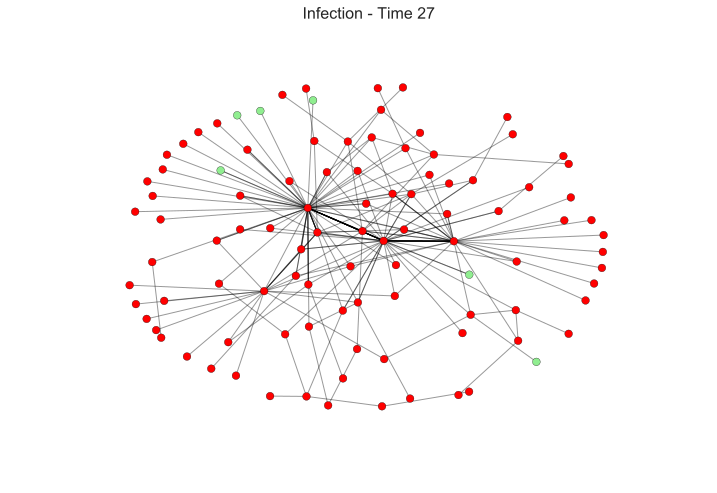

In [15]:
pos=nx.fruchterman_reingold_layout(G)
for i in range(28): 
    
    cor = []
    for j in range(number_of_nodes):
        cor.append(BaseLoggingAgent.open_trial_state_history(dir_path="sim_02", trial_id=0)[i][j]['id'])
    
    cores = []
    for j in cor:
        if j == 1:
            cores.append('red')
        else:
            cores.append('lightgreen')
    
    #plotando a rede
    plt.figure(i, figsize=(12, 8))
    plt.axis('off')
    nx.draw_networkx_nodes(G,pos,node_size=60,node_color=cores)
    nx.draw_networkx_edges(G,pos,alpha=.4)
    plt.title('Infection - Time '+str(i), size=16)
    plt.show()
    
    #if i < 9:
    #    plt.savefig('image00'+str(i+1)+'.png')
    #elif i >= 9:
    #    plt.savefig('image0'+str(i+1)+'.png')

